# Классификация пород собак
Многоклассовая классификация изображений, содержащих породы собак при помощи TensorFlow  и TensorFlow Hub.

## 1. Задача
Определить породу собаки по изображению.
Например, сфотографировав собаку на улице, определить какой она породы.

## 2. Датасет

Датасет взят с соревнований Kaggle: https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 3. Оценка

Оценкой является файл с вероятностями относящимимся к каждой породе собак тестовой выборки


### 4. Переменные

Некоторая информация о данных.
* Имеем дело и изображениями(неструктурированные данные), поэтому будем использовать deep/transfer learninfg
* Даны 120 пород собак (это значит, что существует 120 классов)
* В тренировочной выборке более 10 000 размеченных изображений  (в каждой картинке есть подпись какой породе принадлежит собака)
* В тестовой выборке также более 10 000 неразмеченных изображений



In [2]:
# Распакуем данные с гугл диска
#!unzip "drive/My Drive/Dog vision/dog-breed-identification (1).zip" -d "drive/My Drive/Dog vision/"

### Настроим рабочее пространство
* Импортировать TensorFlow 2.х
* Импортировать TensorFlow Hub
* Убедиться, что мы используем GPU

In [3]:
# Импортируем необходимые инструменты
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Huab version:", hub.__version__)

# Проверим доступность GPU
print("GPU", "доступен" if tf.config.list_physical_devices("GPU") else "не доступно :(")

TF version: 2.2.0
TF Huab version: 0.8.0
GPU доступен


## Подготовим наши данные (конвертируем в тензоры)

Для всех моделей машинного обучения наши данные должны быть представлены в числовом формате. Поэтому первым делом, коневертируем наши изображения в тезоры (числовое представление изображений)

Начнем с просмотра ответов к тренировочному датасету.

In [4]:
# Посмотрим на наши ответы к тренировочному датасету
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Dog vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     0dde7ba887ee083616993d5892db139f  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [5]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

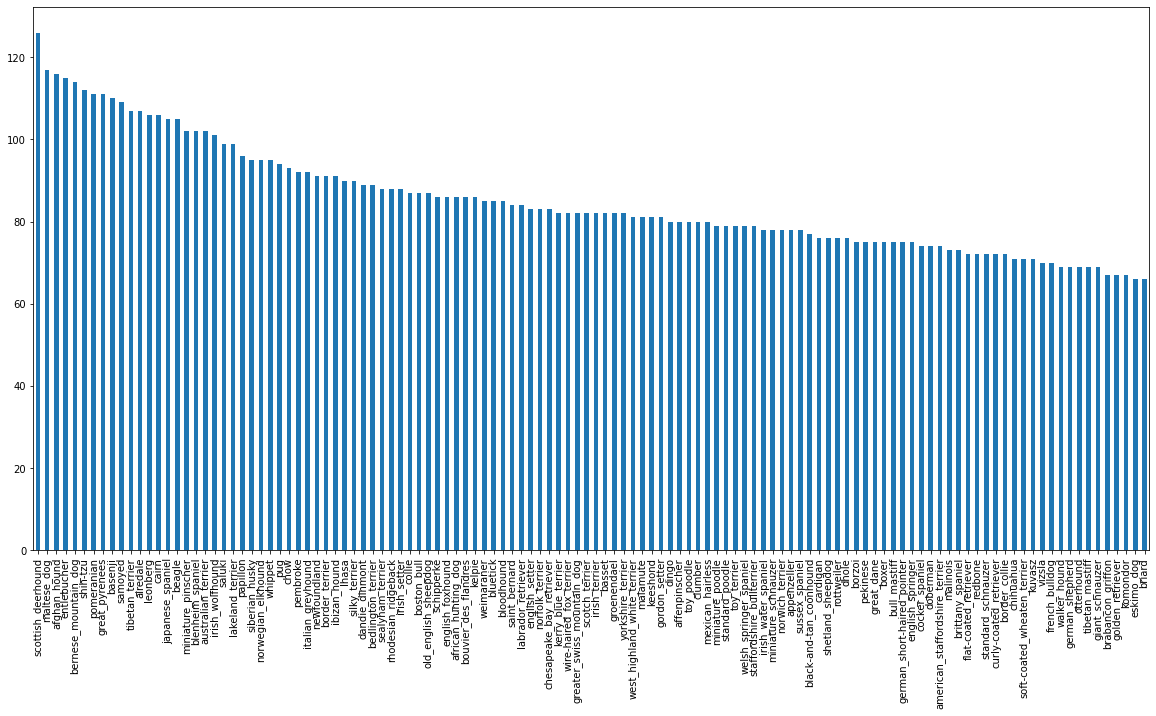

In [6]:
# Сколько изображений каждой породы
labels_csv.breed.value_counts().plot.bar(figsize=(20, 10))

In [7]:
labels_csv.breed.value_counts().median()

82.0

In [8]:
get_ipython().__class__.__name__ = "ZMQInteractiveShell"

In [9]:
get_ipython().__class__.__name__

'ZMQInteractiveShell'

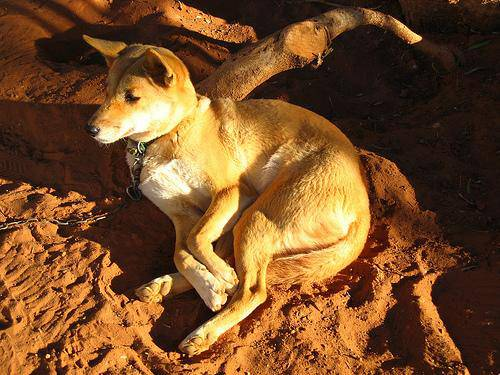

In [10]:
# Посмотрим на изображения
from IPython.display import Image,display
display(Image('drive/My Drive/Dog vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'))



### Выведем изображения и их метки

Получил список путей с изображениями

In [11]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [12]:
# Создадим пути из названий изоражений
filenames = ["drive/My Drive/Dog vision/train/" + fname +".jpg" for fname in labels_csv["id"]]

# Проверим первые 10
filenames[:10]

['drive/My Drive/Dog vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [13]:
import os
os.listdir("drive/My Drive/Dog vision/train/")[:10]

['f588238227e5822b0c83a8355eccd067.jpg',
 'eb9dedfc29135debc82e82f159c23fa1.jpg',
 'f21952d038bd3c41c89def1a1d92385e.jpg',
 'ea8a9c29c83b5f3d4b917922a0ce9066.jpg',
 'ee4f333b5dbfab72ccd4225f81920e8f.jpg',
 'f24f230f4a39f5411546ab1da48cc196.jpg',
 'ece92625596397f614310352584d7b74.jpg',
 'ea7f0c67bf41d5f2afe2e8e5a9c08774.jpg',
 'f2d229962b94228f494c9cb3c0ffe740.jpg',
 'e9aaa8964f450f990a7a3c4228bb844d.jpg']

In [14]:
# Проверим если количество путей совпадает с количеством изображений
import os
if len(os.listdir("drive/My Drive/Dog vision/train/")) == len(filenames):
  print("Количество путей файлов совпадает с количеством изображений")
else:
  print("Количество путей файлов не совпадает с количеством изображений, проверьте путь.")

Количество путей файлов совпадает с количеством изображений


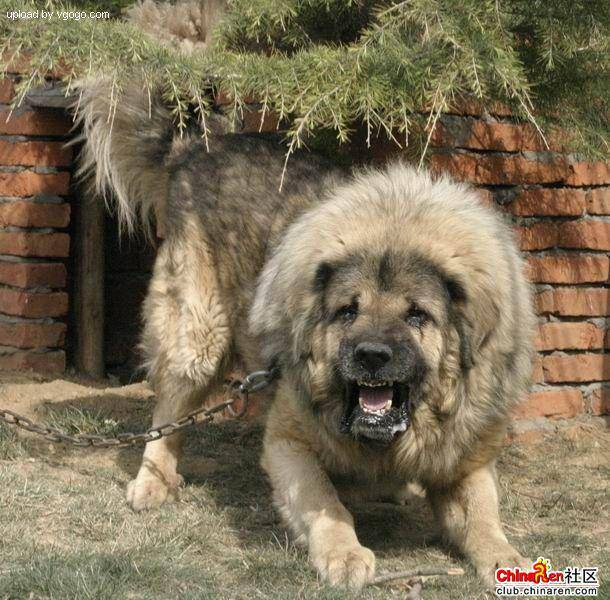

In [15]:
# Еще одна проверка
Image(filenames[9000])

In [16]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Теперь у нас есть данные о путях наших изображений, теперь подготовим метки

In [17]:
import numpy as np

labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) # делает тоже самое 

labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [18]:
len(labels)

10222

In [19]:
# Проверим количество меток совпадает с количеством путей к файлам
if len(labels) == len(filenames):
  print("Количество меток совпадает с количеством путей!")
else:
  print("Количество меток не совпадает к количеством путей к ним. Проверьте путь к файлам")


Количество меток совпадает с количеством путей!


In [20]:
# Проверим количество уникальных значений
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [21]:
# Коневртируем одну метку в булевый массив
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [22]:
# Коневертируем каждую метку в булевый массив
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [23]:
len(boolean_labels)

10222

In [24]:
# Пример конвертации булевых переменных в числовые
print(labels[0]) # Метка
print(np.where(unique_breeds==labels[0])) # индекс где встречается метка
print(boolean_labels[0].argmax()) # индекс где встречаетсяя метка в булевом массиве
print(boolean_labels[0].astype(int)) # будет 1 где метка появится

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Создадим валидирующу выборку
Так как ее нет на сайте Kaggle, создадим валидуюрую выборку

In [25]:
# Создадим Х и y
X = filenames
y = boolean_labels

Начнем экспериментировать с 1 000 изображений и будем увелчичивать количество изображений

In [26]:
# Зададим количество изображений для экспериментов
NUM_IMAGES = 1000 #@param{type:"slider", min:1000, max:10000, step:1000}

In [27]:
# Разделим нашу выборуку на тренировочную и валидирующую
from sklearn.model_selection import train_test_split

# Разделим на тренировочную и валидирующую с количеством изображений равной NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[: NUM_IMAGES], 
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [28]:
# 
X_train[:2], y_train[:2]

(['drive/My Drive/Dog vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, F

### Подготовим изображения (конвертируем их в тензоры)

Для препроцессинга изображений в тензоры мы напишем функцию, которая делает несколько вещей:
1. В качестве входных данных будем использовать путь к файлу
2. Использует TensorFlow для того, чтобы прочитать файл и сохранить его в переменную, `image`
3. Конвертурует `image` (jpg) в тензоры
4. Нормализируем наше изображение (конвертируем канал цвета из 0-255 в 0-1).
5. Изменяет размер `image' до (224, 224, )
6. Выводит измененную переменную `image`

In [29]:
# Конвертируем изобажение в массив Numpy
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape


(257, 350, 3)

In [30]:
image.min(), image.max()

(0, 255)

In [31]:
# Конвертируем изображение в тензор
tf.constant(image)[:2]



<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Теперь напишем функцию:
В качестве входных данных будем использовать путь к файлу
Использует TensorFlow для того, чтобы прочитать файл и сохранить его в переменную, image
Конвертурует image (jpg) в тензоры
Изменяет размер `image' до (224, 224, )
Выводит измененную переменную image

In [32]:
# Определим размер изображения
IMG_SIZE = 224


# Создадим функцию для препроцессинга изображений

def process_image(image_path, img_size=IMG_SIZE):
  """
  На вход подается путь к изображению и функция конвертирует изображение в тезор.
  """
  # Считаем изображение
  image = tf.io.read_file(image_path)
  # Конвертируем изображение в формате jpeg в числовой тензор с 3 каналами (красный, зеленый и синий)
  image = tf.image.decode_jpeg(image, channels=3)
  # Конвертируем каналы цвета из диапазано 0-255 в диапазон 0-1(нормализуем)
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Изменим размер наших рисунков до (224, 224)
  image = tf.image.resize(image, size=(IMG_SIZE, IMG_SIZE))

  return image

### Конвертируем наши изображения в батчи (batch)

Если мы попытаемся задействовать все 10 000 изображений за один раз, есть вероятность, что они не "поместятся" в оперативную память

Поэтому мы будем использовать  пакет (batch), состоящий из 32 изображений (мы сможем вручну настроить размер пакета, если это необходимо).

Для того, чтобы ипользовать TensorFlow эффективно нам необходимо, чтобы наши данные находились в формате кортежа (typle), который выглядит слудующим образом:
`(image, label)`.



In [33]:
# Создадим функцию , которая возвращает кортеж (image, label)
def get_image_label(image_path, label):
  """
  Берет путь файла и его метку, подготавливает изображение и возвращает 
  кортеж (image, label).
  """

  image = process_image(image_path)
  return image, label

In [34]:
# Проверим как будет работать функция
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Теперь у нас есть возможность возвращать наши данные в виде кортежей тензоров `(image, label)` сделаем функцию для того, чтобы коневртировать наши данныые (`X` и `y`)

In [35]:
# Определим размер батча, 32 это хороший размер
BATCH_SIZE = 32

# Создадим функцию для преобразования в батчи(пакеты)
def create_data_batches (X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Создадает пакеты данных из изображений (X) и меток (y) в виде пары.
  Перемешивает данные если функция используется на тренировочной выборке, но не перемешивает - если
  на валидуриющей.
  Также повзволяет подготовить тестовую выборку (в которой нет меток)
  """
  # Если выборка представлет их себя тестовый датасет у нас скорее  всего не будет меток для ее
  if test_data:
    print("Создаются пакеты для тестовой выборки...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Только пути к файлам (без меток)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

    # Если на вход поступает валидирующая выборка нам не нужно перемешивать ее
  elif valid_data:
    print("Создаются пакетs для валидирующей выборки...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # Пути к файлам
                                               tf.constant(y))) #  метки
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)       
    return data_batch

  else:
    print("Создаются пакеты для тренировочной выборки...")    
    # Конвертируем пути файлов и метки в тензоры
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y))) 
        
    # Перемешаем пути файлов и метки до того, как их подать на вход в конвертирующую функцию process_image (Это будет быстрее чем перемешывать изображения)
    data = data.shuffle(buffer_size=len(X))

    # Создает кортеж (image, label) (также конвертирует путь к файлу на подготовленное к маш. обуч. изображение)
    data = data.map(get_image_label)

    # Представим наши данные ввиде батчей
    data_batch = data.batch(BATCH_SIZE)

    return data_batch



In [36]:
# Создадим тренировочные и валидирующие батчи
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Создаются пакеты для тренировочной выборки...
Создаются пакетs для валидирующей выборки...


In [37]:
# Проверим некоторые свойства наших батчей
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Визуализируем пакеты данных
Наши данные сейчас находятся в пакетах, однако довольно сложно понять как они выглядят, визуализируем их

In [38]:
import matplotlib.pyplot as plt

# Создадим функцию для визуализации изображений в наших пакетах данных
def show_25_image(images, labels):
  """
  Выводит 25 изображений и их меток из пакета данных
  """
  # Настроим рисунок
  plt.figure(figsize=(10, 10))
  # Создадим цикл для отображения 25 изображений
  for i in range(25):
    # Создадим сабплоты (5 строк, 5 столбцов)
    ax = plt.subplot(5, 5, i+1)
    # Отобразим изображение
    plt.imshow(images[i])
    # Добавим метку изображение в качестве подписи
    plt.title(unique_breeds[labels[i].argmax()])
    # Отключим линии сетки
    plt.axis("off")


In [39]:
train_images, train_labels = next(train_data.as_numpy_iterator())
# train_images, train_labels

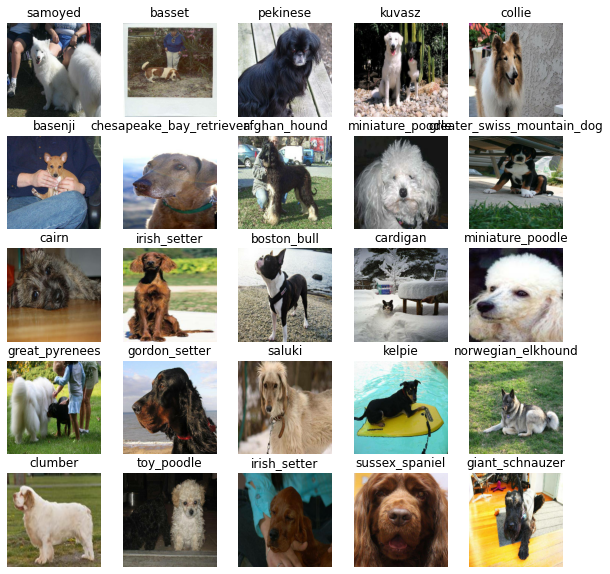

In [40]:
# Визуализируем данные из тренировочной выборки
show_25_image(train_images, train_labels)

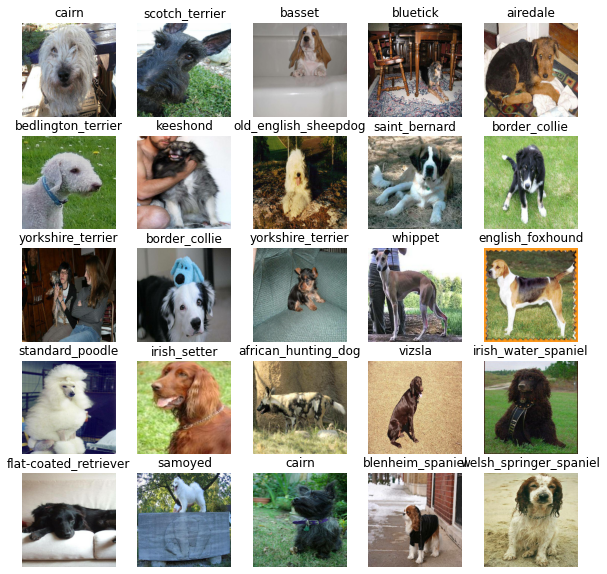

In [41]:
# Визуализируем тренировочную выборку
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_image(val_images, val_labels)

### Создадим модель

До того как создат модель, нам нужно определить несколько вещей:
1. Размер входных данных, в нашем случае изображений в формате тензоров.
2. Размерх выходных данных, в нашем случае метки с названием породы в формте тензоров.
3. URL модеди, которую хотим использовать
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [42]:
# Настроим размерх входных данных для модели
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # Пакет, ширина, высота, каналы цветов

# Настроим размер выходных данных модели
OUTPUT_SHAPE = len(unique_breeds)

# Укажем URL модели из TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"


Теперь, когда у нас есть входные и выходные данные для модели, укажим их в модели глубокого обучения Keras.

Создадим функцию, которая:
* На вход берет размер входных и выходных данных, выбранную модель.
* Определят слои в модели Keras (будем использовать последовательную модель Sequential)
* Компилирует модель (покзывает как должна быть оценена модель и улучшена)
* Строит модель. 
* Возвращает модель.
Все шаги можно найти здесь:
https://www.tensorflow.org/guide/keras/overview?hl=ru


In [43]:
# Создадим функцию которая строит модель в Keras
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_URL=MODEL_URL):
  print("Строим модель с помощью:", MODEL_URL)

  # Настроим слои модели
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Первый слой (входной слой)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Второй слой (выходной слой)
  ])

  # Компилируем модель
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Построим модель
  model.build(INPUT_SHAPE)

  return model


In [44]:
model = create_model()
model.summary()

Строим модель с помощью: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Создадим обратну связь

Обратная связь позволяет представялет из себя полезные функции, которые может использоват модель, для того, чтобы сохранить свой прогресс, проверить его и/или остановить обучение, если модель не улучшается.

Создадим две функции обратной связи, одну для TensorBoard, которая помогает отслеживать прогресс нашей модели и вторую для ранней остановки модели, которая предотвратит от слишком долго обучения нашей модели.

### Обратная связь TensorBoard
Для того, чтобы настроить обратную связь нужно сделать 3 вещи:
1. Закгрузить расширение TensorBoard в наш ноутбук
2. Создать callback TensorBoard, которая способна сохранять логи и иметь доступ к функции модели `fit`
3. Визуализировать логи обучения модели с помощью функции `%tensorboard` (будем это делать после обучения)

In [45]:
# Загрузим расширешие  TensorBoard для ноутбука
%load_ext tensorboard

In [46]:
import datetime

# Создадим функцию для TensorBoard callback
def create_tensor_board_callback():
  # создадим папку для сохранение логов TensorBoard
  logdir = os.path.join("drive/My Drive/Dog vision/logs",
                        # Всего отслеживаем логи, когда запущена модель
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Ранний останов обучения

Ранний останов помогает предотвратить переобучение модели, если выбранная метрика перестает улучшаться

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


In [47]:
# Создадим раннюю остановку обучения
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)

### Обучение модели (на небольшой выборке)

Наша первая модель будет обучена только на 1000 рисунках для того, чтобы убедиться, что все хорошо работает

In [48]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [49]:
# Проверим, что мы считаем на GPU

print("GPU", "доступен!!!" if tf.config.list_physical_devices("GPU") else "не доступен :(")

GPU доступен!!!


Создадим функцию, которая тренирует модель

* Cоздает модель при помощи `create_model()`
* Настраивает TensorBoard при помощи `create_tensor_board_callback()`
* вызывает функцию `fit()` нашей модели на обучающей выборке, валидирующей выборке, количество эпох для обучения (`NUM_EPOCHS`), и обратную связь, которую мы хотим использовать
* Возвращает модель

                                          
                                          

In [50]:
# Создадим функцию для обучения обученной модели
def train_model():
  """
  Обучают данную модель и возвращает ее тренированную версию
  """
  # Создадим модель
  model = create_model()

  # Создадим новую сессию каждый раз, когда мы тренируем модель
  tensorboard = create_tensor_board_callback()

  # Обучим модель на данных и будем ...
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Возвращает обученную модель
  return model

In [51]:
# Обучим модель
# model = train_model()

### Проверим  логи TensorBoard

функция TensorBoard (`%tensorboard`) будет иметь доступ к ранее созданной директории и будет визуализировать ее содержимоеьь

In [52]:
% tensorboard --logdir drive/My\ Drive/Dog\ vision/logs

Output hidden; open in https://colab.research.google.com to view.

## Сделаем прогноз, используя тренировочную выборку и оценим модель

In [53]:
# Сделаем прогноз на валидирующей выборке (не участвовала в обучении)
predictions = model.predict(val_data, verbose=1)

7/7 [==============================] - 56s 8s/step


In [54]:
predictions.shape

(200, 120)

In [55]:
np.sum(predictions[1])

1.0

In [56]:
# посмотрим различные прогнозы

index=42

print(predictions[index])
print(f"Максимальное значение(вероятность):{np.max(predictions[index])}")
print(f"Сумма:{np.sum(predictions[index])}")
print(f"Максимальный индекс: {np.argmax(predictions[index])}")
print(f"Предсказанная порода: {unique_breeds[np.argmax(predictions[index])]}")


[0.00412723 0.00207159 0.00634942 0.00105936 0.01094974 0.00118609
 0.00203534 0.00338524 0.00202307 0.0012105  0.02009612 0.17709163
 0.00196527 0.00627919 0.00209368 0.02153523 0.00074652 0.00764136
 0.01974562 0.0036648  0.00412952 0.00192354 0.00264178 0.00559642
 0.0004315  0.00480348 0.00396502 0.00177988 0.01722698 0.00034821
 0.00446987 0.00081285 0.00489506 0.00485606 0.00619232 0.02788653
 0.01211181 0.01632378 0.00706336 0.00255667 0.03348109 0.00378929
 0.0052194  0.04519106 0.01020468 0.00642865 0.00089916 0.00813998
 0.00163163 0.00285668 0.00152329 0.0102944  0.00295667 0.00175308
 0.02024718 0.01270302 0.00320378 0.00133484 0.01057628 0.00354077
 0.00109814 0.00940287 0.00124798 0.00042954 0.0432601  0.00347805
 0.00224809 0.00144698 0.00258408 0.00529138 0.00061282 0.00494769
 0.00686769 0.00459858 0.00586872 0.00091971 0.00862139 0.01675382
 0.00073893 0.00225904 0.00483471 0.01126195 0.00143815 0.00128276
 0.00305475 0.00820363 0.00460171 0.00438045 0.00513407 0.0056

Для большей функциональности было бы хорошо увидеть еще изображение прогноз которого мы сделали

**Примечание :** спрогнозированные вероятности также известны как уровень достоверности 

In [57]:
# Конвертируем уровни достоверности в соответствующую метку
def get_pred_label(prediction_probabilities):
  """
  Конвертирует массив вероятностей в разметку
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Получим спрогнозированную разметку на основе массива предсказанных вероятностей
pred_label = get_pred_label(predictions[81])
pred_label

'english_foxhound'

Так как наша валидирующая выборка до сих пор находится в батче (пакетах),
нам нужно ее достать из пакетов, чтобы сделать прогноз на валидирующих изображениях и потом сравнить прогнозы с разметкой(истинными значениями).

In [58]:
# Создадим функцию для  распаковки датасета
def unbatchify(data):
  """
  Превращает батч (image, label) в тензорном виде и возвращает отедельные массивы
  """
  images = []
  labels = []
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  
  return images, labels


# Распакуем (анбачим) валидирующую выборку

val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Теперь у нас есть возможность выводить:
* прогноз разметки
* валидирующую разметку (истинные значения)
* валидирующие изображения

Напишем код для функций, которые позволяют визуализировать данные.

Создадим функцию, которая:

* Берет массив с вероятностями прогноза, массив с истинной разметкой и массив изображений в числововм виде
* Конвертирует спрогнозированную вероятность разметки в спрогнозированную разметку
* Рисует спрогнозированную разметку, ее вероятность и истинную разметку с изображением в одном рисунке

In [59]:
def plot_pred (prediction_probabilities, labels, images, n=1):
  """
  Визуализирует прогноз, истинное значение породы и изображение для n изображений
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Выведем спрогнизрованную разметку
  pred_label = get_pred_label(pred_prob)

  # Нарисуем изображение и уберем оси
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Поменяем цвет текста названия рисунка в зависимости от правильности прогноза
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Создадим название рисунка: прогноз, вероятность прогноза, и истинное значение
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                              color=color)


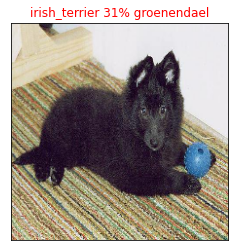

In [60]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Теперь у нас есть функция для визализации прогноза, теперь напишем функцю для визуализации топ-10 вероятностей прогноза для одного изображения

Это функция будет делать следующее:
* На входе получать массив вероятностей спрогнозированной разметки, истинную разметку. 
* Найдет прогноз породы при помощи функции `get_pred_label`
* Найдет топ-10:
  * Индексы спрогнозированных вероятностей
  * Значения  вероятности прогноза
  * Спрогнозированную разметку (в нашем случае породу)
* Визуализирует топ-10 значений вероятности прогноза и разметку (иситинное значение породы) при этом окрасив правильный прогноз в зеленый цвет

In [61]:
def plot_pred_conf (prediction_probabilities, labels, n=1):
  """
  Выводит топ-10 наибольших значений вероятности для истинного значения раметки для образца n
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Выведем предсказанную разметку
  pred_label = get_pred_label(pred_prob)

  # Найдем топ-10 индексов с максимальной вероятностью
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Найдем 10 наибольших вероятностей прогноза
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Найдем 10 спрогнозированных пород
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Настроим визуализацию результатов
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Изменим цвет истинного значения
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

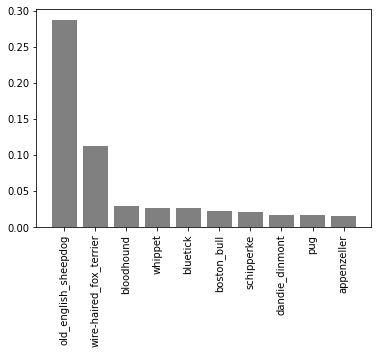

In [62]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels, n=9)

Теперь у нас есть функции, которые помогают визуализировать наш прогноз и оценить нашу модель, проверим их работу.

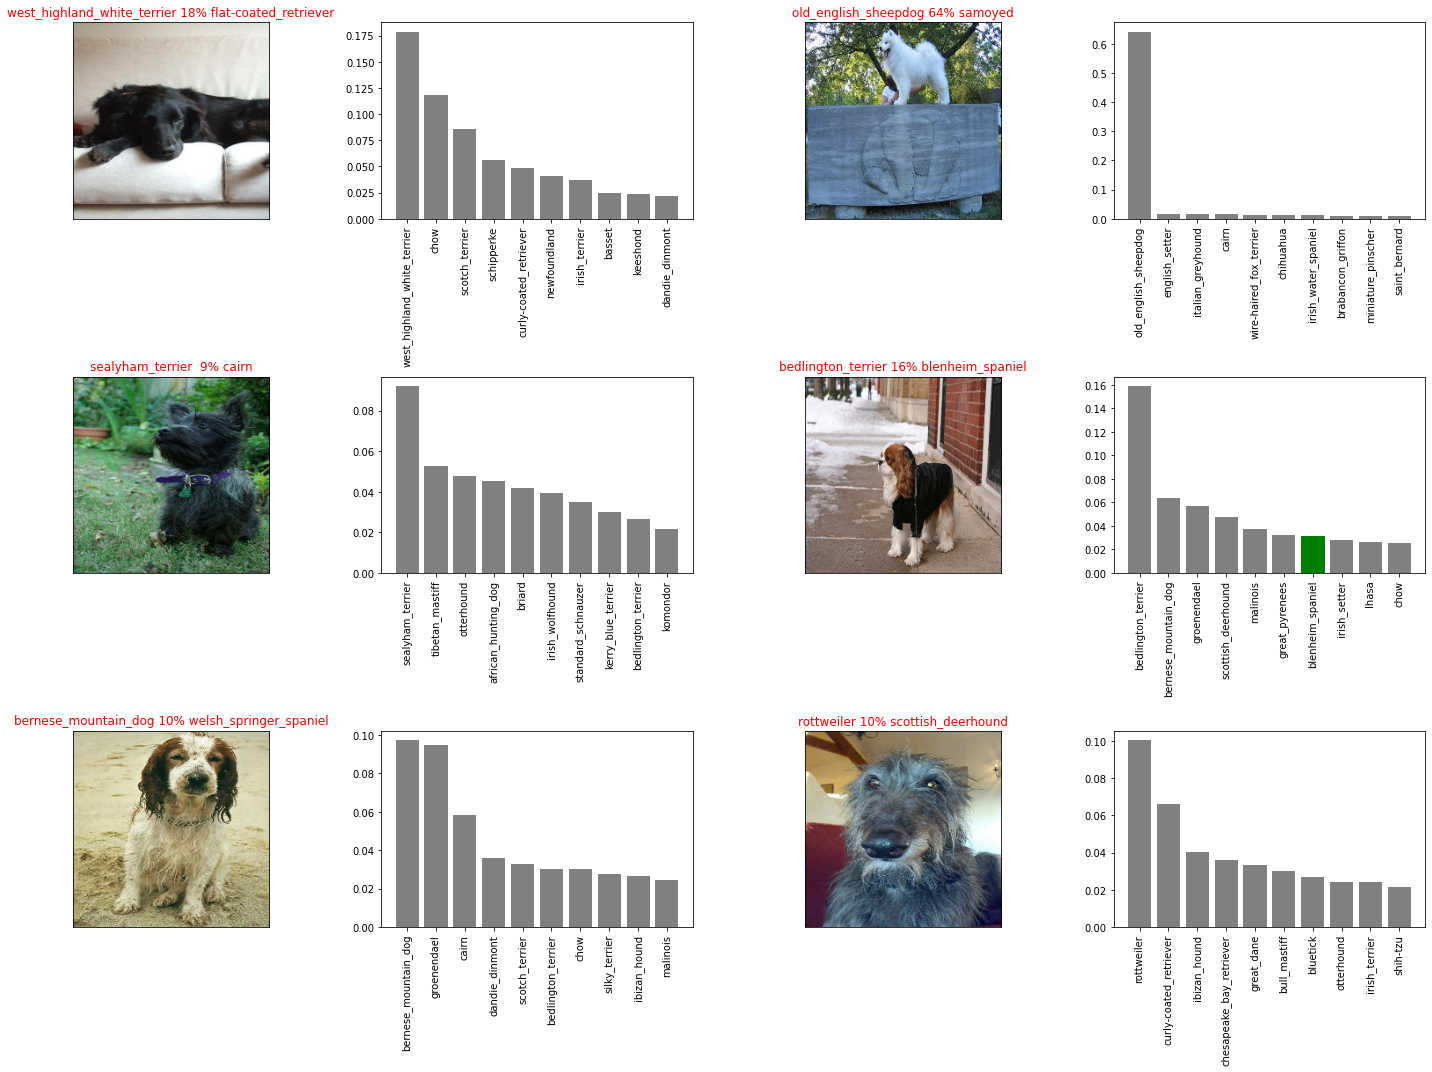

In [63]:
# Проверим несколько прогнозов и их значения
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
  plt.tight_layout(h_pad=1.0)
plt.show()


### Сохраним и загрузим нашу модель 

In [64]:
# Создадим функцию для сохранения модели
def save_model(model, suffix=None):
  """
  Сохраняет данную модель в директорию models и добавляет суффикс(текст)
  """
  # Создадим путь к модели, а также текущее время
  modeldir = os.path.join("drive/My Drive/Dog vision/models", 
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "_" + suffix + ".h5" # расширение модели
  print(f"Сохранение модели в: {model_path}...")
  model.save(model_path)
  return model_path

In [65]:
# Создадим функцию для загрузки сохраненной модели
def load_model (model_path):
  """
  Загружает сохраненную модель из определенного пути
  """
  print(f"Загрузка модели из: {model_path}...")
  model = tf.keras.models.load_model(model_path,
                                    custom_objects={"KerasLayer": hub.KerasLayer})
  return model

Теперь у нас есть функции для сохранения и загрузки модели, убедимся, что они правильно работают

In [66]:
# Сохраним нашу модель, тренированную на 1000 изображений
# save_model(model, suffix="1000-images-mobilenetv2-Adam")


In [67]:
# Загрузим обученную модель
# loaded_1000_image_model = load_model("drive/My Drive/Dog vision/models/20200720-10401595241611_1000-images-mobilenetvv2-Adam.h5")

In [68]:
# Оценим  модель (до сохранения)
# model.evaluate(val_data)

In [69]:
# Оценим загруженную модель
# loaded_1000_image_model.evaluate(val_data)

## Обучим модель на всех данных

In [70]:
len(X), len(y)

(10222, 10222)

In [71]:
# Создадим пакеты данных для всей выборки
full_data = create_data_batches(X, y)

Создаются пакеты для тренировочной выборки...


In [72]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [73]:
# Создадим модель на всех данных
full_model = create_model()

Строим модель с помощью: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [74]:
# Создадим обратные связи для новой модели, осонованной на всех тренировочных данных
full_model_tensorboard = create_tensor_board_callback()
# Нет валидирующей выборки, когда тренировочная выборка состоит из всех данных, поэтому мы не сможем отслеживать валидирующую точность
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Примечание** Выполнение следующей ячейки займет около 2 часов, так как GPU, который мы используем для расчетов должен загрузить все картинки в память.

In [75]:
# Обучим модель на всех данных
# full_model.fit(x=full_data,
#                epochs=NUM_EPOCHS,
#                callbacks=[full_model_tensorboard, full_model_early_stopping])

In [76]:
# save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

In [77]:
# Загрузим модель, обученную на всех данных
loaded_full_model = load_model("drive/My Drive/Dog vision/models/20200720-14231595255002_full-image-set-mobilenetv2-Adam.h5")

Загрузка модели из: drive/My Drive/Dog vision/models/20200720-14231595255002_full-image-set-mobilenetv2-Adam.h5...


## Сделаем прогноз на тестовой выборке

Так как наша модель была обучена на изображениях в виде пакектов (батчей) тензоров, нам нужно конвертировать их в тот же формат.

Мы создали функцию `create_data_batches()`, которая берет список имен файлов на входе и конвертирует их в пакеты тензоров

Для того, чтобы сделать прогноз на тестовой выборке сделаем следующее:
* Выведем названия файлов тестовой выборки
* Конвертируем имена файлов в тестовый набор пакетов с использованием функции `create_data_batches()` и установим параметр `test_data` на `True` (ввиду того, что у тестовой выборки нет разметки).
* Создадим массив прогноза пропуская пакеты тестовой выборки через метод `predict()` нашей модели

In [78]:
# Загрузим тестовую выборку названий изображений
test_path = "drive/My Drive/Dog vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Dog vision/test/f080ee2429dccf56d2693fb8d3235010.jpg',
 'drive/My Drive/Dog vision/test/e9d385cf5f217ce1378bee8c0a89db62.jpg',
 'drive/My Drive/Dog vision/test/f09826fc9cb9aa425caae5f8aaaa8bef.jpg',
 'drive/My Drive/Dog vision/test/f130fade46d3423c601a7b9a16a0333c.jpg',
 'drive/My Drive/Dog vision/test/e8c778896a73d0f6b4f88c564690c9db.jpg',
 'drive/My Drive/Dog vision/test/ed9e75a553dbb4712addc1638693dc03.jpg',
 'drive/My Drive/Dog vision/test/e807c4b5025b0aa4dcbd5df2765aa8e4.jpg',
 'drive/My Drive/Dog vision/test/f41a03e617bde76fef19ec1cf1355d59.jpg',
 'drive/My Drive/Dog vision/test/f3ef677ea2641c7ef7ece6ce1ba11b2f.jpg',
 'drive/My Drive/Dog vision/test/f3925f914650b1edf59ce7da36abda31.jpg']

In [79]:
# Создадим тестовые пакеты данных
test_data = create_data_batches(test_filenames,test_data=True)

Создаются пакеты для тестовой выборки...


In [80]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Примечение:** Вызов метода `predict()` на нашей модели, обученной на всех данных, займет много времени (около полутра часов).

In [81]:
# Сделаем прогноз на тестовой выборке, с использованием загруженных данных
# test_predictions = loaded_full_model.predict(test_data,
#                                              verbose=1)

In [82]:
# Сохраним прогноз (массимв NumPy) в файл csv (для дальнейшего использования)
# np.savetxt("drive/My Drive/Dog vision/preds_array.csv", test_predictions, delimiter=",")

In [83]:
# Загрузим прогноз (массив Numpy) из файла csv
test_predictions = np.loadtxt("drive/My Drive/Dog vision/preds_array.csv", delimiter=",")

In [84]:
test_predictions[:10]

array([[6.15669896e-13, 5.25698454e-08, 1.22516806e-11, ...,
        2.06405057e-05, 2.24379323e-06, 9.10404673e-13],
       [3.03912440e-14, 8.98252989e-13, 3.90063856e-14, ...,
        7.95395595e-16, 7.09433597e-13, 1.73258674e-09],
       [4.25840542e-13, 1.57491395e-10, 1.65914793e-09, ...,
        2.91306907e-08, 1.28934917e-05, 5.58957255e-11],
       ...,
       [4.35124552e-14, 8.83985159e-12, 4.10209925e-13, ...,
        3.32579419e-15, 3.25824537e-16, 1.03983926e-13],
       [1.59697561e-10, 2.16842633e-08, 1.74841510e-08, ...,
        4.35431205e-11, 2.02223509e-06, 3.02922865e-09],
       [1.24722915e-16, 5.61461366e-06, 4.18936668e-14, ...,
        6.89898252e-06, 2.42361044e-11, 5.53669359e-08]])

In [85]:
test_predictions.shape

(10357, 120)

## Подготовим прогноз тестовой выборки к отправке в Kaggle соревнование

Необходимо создать таблицу в формате csv со столбцом ID и столбцами с названиями пород и соответствующей вероятности принадлежности изображенной на картинке собаки к этим породам

Для того, чтобы создать такой формат нам необходимо:
* Создать датафрейм в pandas со столбцом ID и столбцами с названиями пород собак
* Добавить данные к столбцу ID из путей к изображениям
* Добавить данные по спрогнозированным вероятностям в столбцы напротив каждой породы
* Экспортировать датафрейм в csv файл

In [87]:
# Создадим DataFrame при помощи Pandas c пустыми колонками
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [88]:
# Добавим ID тестовой выборки изображений к нашему DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [89]:
preds_df.head()

id  ... yorkshire_terrier
0  f080ee2429dccf56d2693fb8d3235010  ...               NaN
1  e9d385cf5f217ce1378bee8c0a89db62  ...               NaN
2  f09826fc9cb9aa425caae5f8aaaa8bef  ...               NaN
3  f130fade46d3423c601a7b9a16a0333c  ...               NaN
4  e8c778896a73d0f6b4f88c564690c9db  ...               NaN

[5 rows x 121 columns]

In [90]:
# Добавим вероятности прогноза к каждому столбцу с породой собак
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  ... yorkshire_terrier
0  f080ee2429dccf56d2693fb8d3235010  ...       9.10405e-13
1  e9d385cf5f217ce1378bee8c0a89db62  ...       1.73259e-09
2  f09826fc9cb9aa425caae5f8aaaa8bef  ...       5.58957e-11
3  f130fade46d3423c601a7b9a16a0333c  ...       3.27008e-13
4  e8c778896a73d0f6b4f88c564690c9db  ...       0.000114601

[5 rows x 121 columns]

In [ ]:
# Сохраним наш прогноз в формате csv для участия в Kaggle
preds_df.to_csv('drive/My Drive/Dog vision/ full_model_submission_1_mobilenetv2.csv', 
                index=False)

## Сделаем прогноз на своих изображениях

Для того, чтобы сделать прогноз на изображениях необходимо
* Вывести путь к изображениям
* Конвертировать пути в пакеты данных с использованием функции `create_databathes()`и так как наши изображения будут без разметки мы установим параметр `test_ data` на `True`
* Пропустим наш пакет данных из изображениями через метод `predict()`
* Конвертируем полученные вероятности прогноза в прогнозируемую разметку
* Сравним спрогнозируемую разметку с нашими изображениями.

In [92]:
# выведем пути к нашим изображениям
custom_path = "drive/My Drive/Dog vision/my-dog-photos/"
custom_image_paths = [custom_path +fname for fname in os.listdir(custom_path)]

In [93]:
custom_image_paths

['drive/My Drive/Dog vision/my-dog-photos/max.jpg']

In [94]:
# Конвертируем наши изображения в патчи данных
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Создаются пакеты для тестовой выборки...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [95]:
# Теперь можно сделать прогноз на наших картинках
custom_preds = loaded_full_model.predict(custom_data)

In [96]:
custom_preds.shape

(1, 120)

In [97]:
# Выведем спрогнозированную разметку для наших изображений
custom_pred_label = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]

In [98]:
custom_pred_label

['american_staffordshire_terrier']

In [99]:
# Выведем наши изображения (наша фунция unbatchify() не будет работать так как у нас нет истинной разметки)
custom_images = []
# Цикл для распаковки данных
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

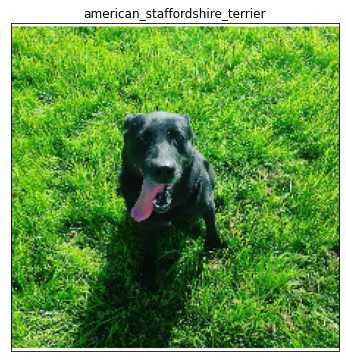

In [101]:
# Проверим наш прогноз 
plt.figure(figsize=(20,20))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_label[i])
  plt.imshow(image)